# Lab 3: ATLAS Data Analysis

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy

# useful constants:
mZ = 91.1880 #GeV/c^2
s_mZ = 0.0020 #GeV/c^2
mW = 80.3692 #GeV/c^2
s_mW = 0.0133 #GeV/c^2
mH = 125.2 #GeV/c^2
s_mH = 0.11 #GeV/c^2
me = 0.51099895 #GeV/c62
s_me = 0.00000000015 #GeV/c^2
mMu = 105.6583755 #MeV/c^2
s_mMu = 0.0000023 #MeV/c^2
mTau = 1776.93 #MeV/c^2
s_mTau = 0.09 #MeV/c^2

## Part 1

In [2]:
data = np.loadtxt("atlas_z_to_ll.csv", delimiter=",", skiprows=1)
pt1 = data[:,0]
pt2 = data[:,1]
eta1 = data[:,2]
eta2 = data[:,3]
phi1 = data[:,4]
phi2 = data[:,5]
E1 = data[:,6]
E2 = data[:,7]


p1 = np.array([pt1*np.cos(phi1), pt1*np.sin(phi1), pt1*np.sinh(eta1)])
p2 = np.array([pt2*np.cos(phi2), pt2*np.sin(phi2), pt2*np.sinh(eta2)])
E =  E1+E2
p = p1+p2

M = np.sqrt(E**2-(p[0]**2+p[1]**2+p[2]**2))

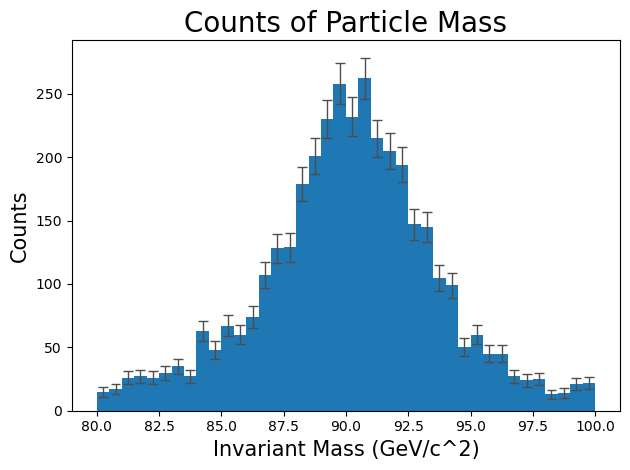

In [3]:
bins = np.linspace(80,100,41)
binsize=bins[1]-bins[0]

fig, ax = plt.subplots(1,1)
n, b, p = ax.hist(M, bins=bins)
b = b[0:-1]
s_n = np.sqrt(n)
ax.vlines(b+binsize/2, n-s_n, n+s_n, color=(0.3,0.3,0.3), linewidth=1)
ax.hlines(n-s_n, b+binsize*0.1, b+binsize-binsize*0.1, color=(0.3,0.3,0.3), linewidth=1)
ax.hlines(n+s_n, b+binsize*0.1, b+binsize-binsize*0.1, color=(0.3,0.3,0.3), linewidth=1)
ax.set_xlabel("Invariant Mass (GeV/c^2)", fontsize=15)
ax.set_ylabel("Counts", fontsize=15)
ax.set_title("Counts of Particle Mass", fontsize=20)
fig.tight_layout()

## Part 2

In [28]:
def D(m, m0, gamma):
    return (gamma)/(2*np.pi*((m-m0)**2+(gamma/2)**2))

mask = (b+binsize/2>87)&(b+binsize/2<93)
dataX = b[mask]+binsize/2
dataY = n[mask]

param, covar = curve_fit(D,dataX, dataY/np.sum(dataY), sigma=s_n[mask]/np.sum(dataY), absolute_sigma=True)

evalX = np.linspace(bins[0], bins[-1], 1000)
fit = D(evalX, param[0], param[1])

m0,gamma=param
s_m0, s_gamma = np.sqrt(np.diag(covar))
print(f"m0: ({m0} +- {s_m0}) GeV/c^2\ngamma: ({gamma} +- {s_gamma}) GeV/c^2")

m0: (90.31604650694128 +- 0.08721580016991519) GeV/c^2
gamma: (6.000088227253159 +- 0.17377788043587303) GeV/c^2


Text(0, 0.5, 'Counts')

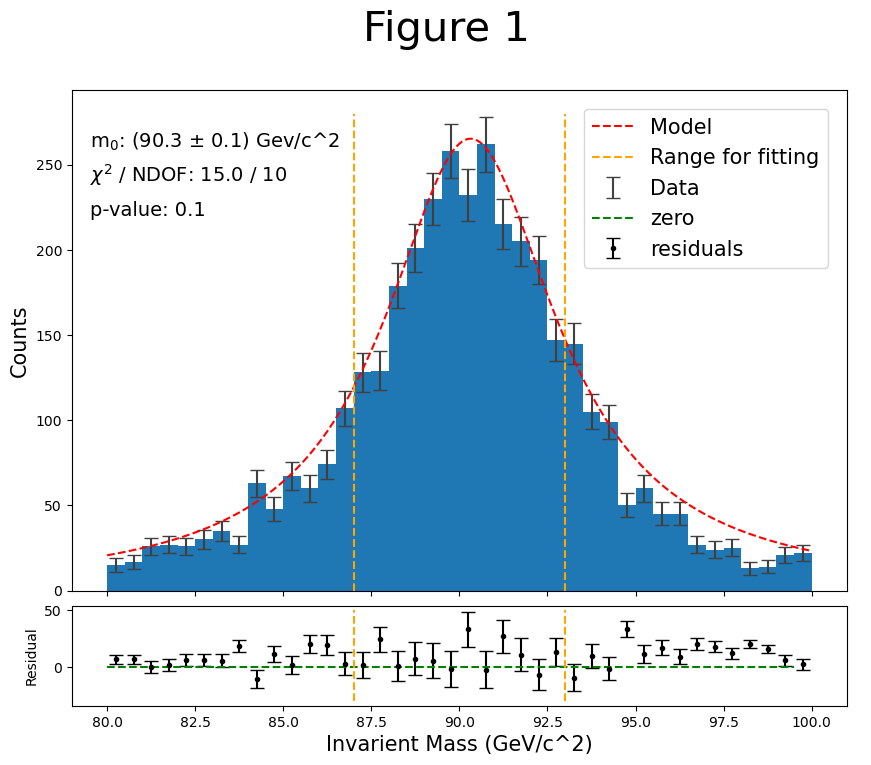

In [107]:
fig, (axd,axr) = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios':[5,1], 'hspace':0.05}, figsize=(10,8))
axd.hist(M, bins=bins)
axd.errorbar(b+binsize/2, n, s_n, fmt=" ", capsize=5, color=(0.25,0.25,0.25), label="Data")
axd.plot(evalX, fit*5000/2, color="red", linestyle="--", label="Model")

model = 5000./2.*D(dataX,param[0],param[1])
residuals = model-dataY
chi2 = np.sum((residuals/s_n[mask])**2)
ndof = len(model)-2
reducedChi2=chi2/(len(dataX))
pval = scipy.stats.chi2.sf(chi2, ndof)
axd.text(79.5,260,f"m$_0$: ({m0:.1f} $\\pm$ {s_m0:0.1f}) Gev/c^2", fontsize=14)
axd.text(79.5,240,f"$\\chi^2$ / NDOF: {chi2:.1f} / {ndof}", fontsize=14)
axd.text(79.5,220,f"p-value: {pval:.1f}", fontsize=14)

plotRes = 5000./2.*D(b+binsize/2, param[0],param[1])-n
axr.errorbar(b+binsize/2, plotRes,yerr = s_n,capsize=5, fmt=".k", label="residuals")
axr.hlines(0,np.min(b),np.max(b),linestyle="--",color="green",label="zero")
fig.suptitle("Figure 1", fontsize=30);
axd.vlines((dataX[0]-binsize/2,dataX[-1]+binsize/2),0,280, linestyle="--",color="orange",label="Range for fitting")
axr.vlines((dataX[0]-binsize/2,dataX[-1]+binsize/2),-30,50, linestyle="--",color="orange")

fig.legend(loc=(0.67,0.65),fontsize=15)
axr.set_xlabel("Invarient Mass (GeV/c^2)", fontsize=15)
axr.set_ylabel("Residual")
axd.set_ylabel("Counts",fontsize=15)